# Import necessary packages

In [2]:
import os
import random
import numpy as np
import glob
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from sklearn.model_selection import KFold, train_test_split
import cv2

import tensorflow as tf

from keras.backend import clear_session
from keras import backend as K
from keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG16 
from keras.layers import Input, BatchNormalization, Activation, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, img_to_array

#unet collection
from keras_unet_collection import models, losses
#import tensorflow as tf
from datetime import datetime 
from PIL import Image


# U-Net++ with Keras unet collection

In [4]:
image_directory = 'D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_images_RF/insert_images/'
mask_directory = 'D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_masks_RF/insert_masks/'

SIZE = 256
image_dataset = []
mask_dataset = []

#define custom function
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

#callback
callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint('A_model2plusV1.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger('A_model2plusV1.csv', separator=',', append=False)
]

images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))


masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

#split dataset into training and validation set
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

num_labels = 1  #Binary
batch_size = 2
epochs = 60

model_Unet_plus = models.unet_plus_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024], 
                           n_labels=num_labels, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone="VGG16", weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='unet_plus')


model_Unet_plus.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3), 
              metrics=['accuracy', IoU])

#print(model_Unet_plus.summary())

start2 = datetime.now() 

Unet_plus_history = model_Unet_plus.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)

#print("Those are the metrics", model_Unet_plus.evaluate(X_test, y_test))
stop2 = datetime.now()
#Execution time of the model 
execution_time_Unet_plus = stop2-start2
print("UNet plus execution time is: ", execution_time_Unet_plus)

C:\Users\Noah\AppData\Roaming\Python\Python38\site-packages\keras_unet_collection\_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


Epoch 1/60
230/230 [==============================] - 538s 2s/step - loss: 0.1863 - accuracy: 0.9453 - IoU: 0.9088 - val_loss: 0.0902 - val_accuracy: 0.9685 - val_IoU: 0.9797

Epoch 00001: val_loss improved from inf to 0.09019, saving model to A_model2plusV1.h5
Epoch 2/60
230/230 [==============================] - 536s 2s/step - loss: 0.0596 - accuracy: 0.9732 - IoU: 0.9752 - val_loss: 0.0578 - val_accuracy: 0.9780 - val_IoU: 0.9867

Epoch 00002: val_loss improved from 0.09019 to 0.05778, saving model to A_model2plusV1.h5
Epoch 3/60
230/230 [==============================] - 540s 2s/step - loss: 0.0474 - accuracy: 0.9774 - IoU: 0.9815 - val_loss: 0.0664 - val_accuracy: 0.9775 - val_IoU: 0.9867

Epoch 00003: val_loss did not improve from 0.05778
Epoch 4/60
230/230 [==============================] - 552s 2s/step - loss: 0.0416 - accuracy: 0.9795 - IoU: 0.9841 - val_loss: 0.0916 - val_accuracy: 0.9756 - val_IoU: 0.9867

Epoch 00004: val_loss did not improve from 0.05778
Epoch 5/60
230/230

# U-Net++ with Keras unet collection and k-fold-cross-validation (k = 5)

In [6]:
#define directory where images and masks are located
image_directory = 'D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_images_RF/insert_images'
mask_directory = 'D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_images_RF/insert_masks/'

#define the 
SIZE = 256
image_dataset = []
mask_dataset = []

#define custom function
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

#enumerate and resize images/masks
images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

num_labels = 1  #Binary
batch_size = 1
epochs = 1
num_folds = 5

#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=False)

# Define per-fold score containers 
acc_per_fold = []
loss_per_fold = []
IoU_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(image_dataset, mask_dataset):

  callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint(f'K-foldno{fold_no}-Unet-2d-plus-V3-VL-256.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger(f'K-foldno{fold_no}-Unet-2d-plus-V3-VL-256.csv', separator=',', append=False)]

  # Define the model architecture
  # unet_plus_2d require depth >= 2
  model = models.unet_plus_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024], 
                           n_labels=num_labels, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           output_activation='Sigmoid', 
                           batch_norm=False, pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='unet_plus')

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3), 
              metrics=['accuracy', IoU])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  Unet_plus_history = model.fit(image_dataset[train], mask_dataset[train], 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(image_dataset[test], mask_dataset[test]), 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)
  
  #append evaluation values for every fold to a list
  acc_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[1])
  loss_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[0])
  IoU_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[2])

  # Increase fold number
  fold_no += 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]} - IoU: {IoU_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> IoU: {np.mean(IoU_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
25/25 [==============================] - 26s 1s/step - loss: 0.6545 - accuracy: 0.8897 - IoU: 0.7192 - val_loss: 0.2711 - val_accuracy: 0.9037 - val_IoU: 0.9543

Epoch 00001: val_loss improved from inf to 0.27107, saving model to K-foldno1-Unet-2d-plus-V2-VL-256.h5
1/1 [==============================] - 2s 2s/step - loss: 0.2711 - accuracy: 0.9037 - IoU: 0.9543
------------------------------------------------------------------------
Training for fold 2 ...
25/25 [==============================] - 26s 1s/step - loss: 1.7407 - accuracy: 0.8060 - IoU: 0.7344 - val_loss: 0.2005 - val_accuracy: 0.9034 - val_IoU: 0.9563

Epoch 00001: val_loss improved from inf to 0.20055, saving model to K-foldno2-Unet-2d-plus-V2-VL-256.h5
1/1 [==============================] - 2s 2s/step - loss: 0.2005 - accuracy: 0.9034 - IoU: 0.9563
------------------------------------------------------------------------
Train

In [2]:
# Test whether GPU is present and recognized
# Limit memory allocation

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


## Define custom functions

In [3]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding = "same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding = "same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs) #32
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    
    return x

def build_vgg16_unet(input_shape):
    inputs = Input(input_shape)
    
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor = inputs)
    #vgg16.summary()
    
    """ Encoder """
    
    # skip connections
    s1 = vgg16.get_layer("block1_conv2").output # 256
    s2 = vgg16.get_layer("block2_conv2").output # 128
    s3 = vgg16.get_layer("block3_conv3").output # 64
    s4 = vgg16.get_layer("block4_conv3").output # 32

    """ Bottleneck/Bridge """
    
    b1 = vgg16.get_layer("block5_conv3").output # 16
    
    """ Decoder """

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    """ Outputs """
    outputs = Conv2D(1, (1, 1), padding = "same", activation="sigmoid")(d4) #binary segmentation
    model = Model(inputs, outputs, name = "VGG16_U-Net")
    return model
    

In [4]:
# Convolution block
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), \
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# Create u-net model
def get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    
    # Contracting Path
    # c is output tensor of conv layers
    # p ist output tensor of max pool layers
    # u is output tensor of up-sampling (transposed) layers
    # Batchnorm standardizes/normalizes the output of each layer where applied in order to avoid huge weights using 
    # z-scores 
    
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Compute Intersection over union (IoU), a measure of labelling accuracy
# NOTE: This is sometimes also called Jaccard score
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

def dice_score(y_true, y_pred, smooth=1):
    
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_coef_loss(y_true, y_pred):
    
    return 1 - dice_score(y_true, y_pred)

def dice_bce_score(y_true, y_pred, smooth=1):    
    
    BCE =  K.binary_crossentropy(y_true, y_pred)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)    
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(y_true, -1) + K.sum(y_pred, -1) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

def focal_loss(y_true, y_pred, alpha=0.8, gamma=2):    
      
    BCE = K.binary_crossentropy(y_true, y_pred)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    return focal_loss

# Plot sample of model prediction
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 4, figsize=(30, 20))
    ax[0].imshow(X[ix, ..., 0], cmap='Greys_r')
    
    ax[0].set_title('US-image', c="white" )
    ax[0].grid(False)

    ax[1].imshow(y[ix].squeeze(), cmap='Greys_r')
    ax[1].set_title('Aponeurosis', c="white")
    ax[1].grid(False)

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap="Greys_r")
    
    ax[2].set_title('Apo-Predicted', c="white")
    ax[2].grid(False)
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=0.5, cmap="Greys_r")
    
    ax[3].set_title('Apo-Picture binary', c="white")
    ax[3].grid(False)
    
    plt.savefig(str(ix)+"Pred_area.tif")

# Save all predictions on disk 
def save_pred_area(binary_preds): 
    for i in range(len(binary_preds)): 
        fig, (ax1)= plt.subplots(1, 1, figsize = (15, 15))
        ax1.imshow(binary_preds[i], cmap="Greys_r", interpolation="bilinear")
        ax1.set_title("Predicted Area")
        plt.savefig(str(i)+"Pred_area.tif") # Saves images to directory of notebook
    

# IMAGE AUGMENTATION

## Use only when training new models and not enough data 

In [16]:
## Input image & mask folder variables and prefix for saved augmented images
# Change before augmentation
input_img_folder = "D:/UniBas/Bachelorarbeit/DeepACSA_images_VL/insert_images/"
input_mask_folder = "D:/UniBas/Bachelorarbeit/DeepACSA_masks_VL/insert_masks/"
img_aug_prefix = "vastus"

# Creating image augmentation function
gen = ImageDataGenerator(featurewise_center=True,
                        featurewise_std_normalization=True,
                        rotation_range=5, 
                        width_shift_range=0.075, 
                        height_shift_range=0.075,
                        zoom_range=0.075,
                        horizontal_flip=True)

ids = os.listdir(input_mask_folder)
seed = 131313
batch_size = 1
num_aug_images = 5 # Number of images added from augmented dataset. 


for i in range(int(len(ids) + 1)):
    
    # Choose image & mask that should be augmented 
    # Directory structur: "root/some_dorectory/"
    chosen_image = ids[i] 
    image_path = input_img_folder + chosen_image 
    mask_path = input_mask_folder + chosen_image
    image = np.expand_dims(plt.imread(image_path),0)# Read and expand image dimensions
    if image.ndim < 4: 
        image = np.expand_dims(image,-1)
    mask = np.expand_dims(plt.imread(mask_path),0)
    if mask.ndim < 4: 
        mask = np.expand_dims(mask,-1)

    # Augment images 
    aug_image = gen.flow(image, batch_size=batch_size, seed=seed, save_to_dir=input_img_folder, save_prefix=img_aug_prefix+str(i), save_format="tif")
    aug_mask = gen.flow(mask, batch_size=batch_size, seed=seed, save_to_dir=input_mask_folder, save_prefix=img_aug_prefix+str(i), save_format="tif")
    seed = seed + 1 
     
    # Add images to folder
    for i in range(num_aug_images):
        next(aug_image)[0].astype(np.uint8)
        next(aug_mask)[0].astype(np.uint8)
        
   

c:\ProgramData\Anaconda3\envs\DeepACSA\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\ProgramData\Anaconda3\envs\DeepACSA\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


KeyboardInterrupt: 

# APONEUROSIS TRAINING

# Set image scaling parameters, determine no. of images for training

In [23]:
# Images will be re-scaled
im_width = 256
im_height = 256
border = 5

# list of all images in the path
ids = os.listdir("D:/UniBas/Bachelorarbeit/DeepACSA_images_VL/insert_images/")
print("Total no. of aponeurosis images = ", len(ids))
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

Total no. of aponeurosis images =  544


# Load images and corresponding labels (masks)

In [24]:
train_images = []
for path in glob.glob("D:/UniBas/Bachelorarbeit/DeepACSA_images_VL/insert_images/"):
    for img_path in glob.glob(os.path.join(path, "*.tif")):
        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (256,256))
        img = img_to_array(img)
        img = img/255.0
        train_images.append(img)  
train_images = np.array(train_images)

train_masks = []
for path in glob.glob("D:/UniBas/Bachelorarbeit/DeepACSA_masks_VL/insert_masks/"):
    for mask_path in glob.glob(os.path.join(path, "*.tif")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (256,256))
        mask = img_to_array(mask)
        mask = mask/255.0
        train_masks.append(mask)
        
train_masks = np.array(train_masks)
train_masks = np.expand_dims(train_masks, axis=3)



# Set up aponeurosis training

In [25]:
# Split data into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_masks, test_size=0.1, random_state=42)

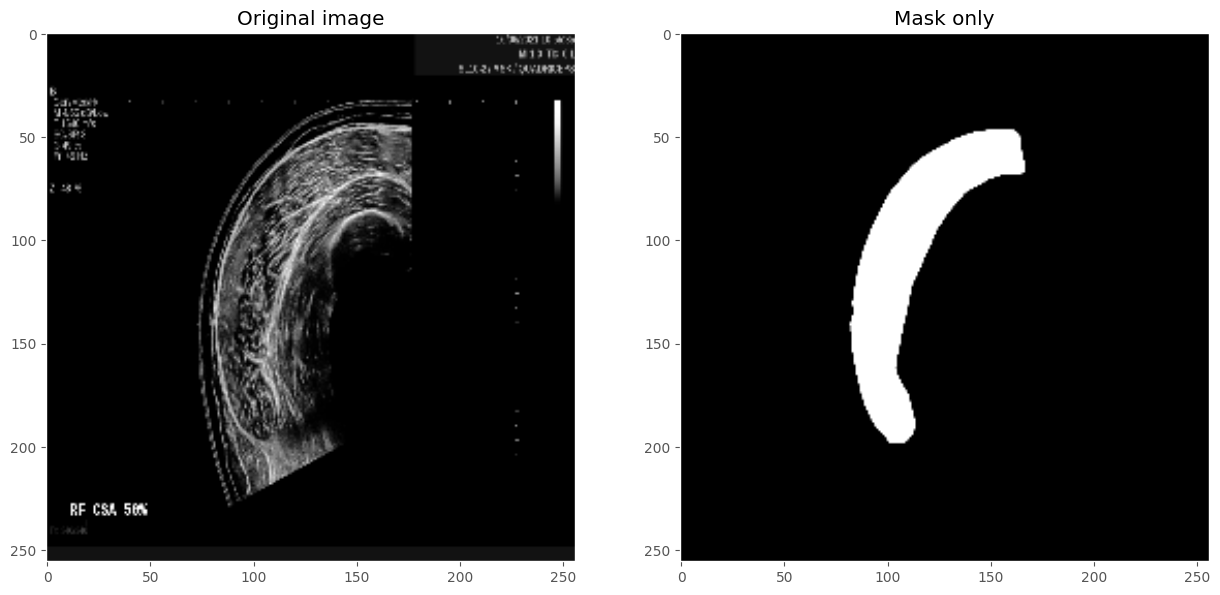

In [26]:
# Visualize a random image along with the mask (not necessary, just for checking)
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # Check whether there's at least 1 aponeurosis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))
ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if at least 1 aponeurosis is present
    #draw the aponeuroses on the original image
    #ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 0, levels = [0.5])
    ax1.set_title('Original image')
    ax1.grid(False)
    ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Mask only')
    ax2.grid(False)

In [27]:
# Compile the aponeurosis model VGG16
VGG16_UNet = build_vgg16_unet((256,256,3))
model_apo = VGG16_UNet
model_apo.compile(optimizer=Adam(), loss=dice_bce_score, metrics=["accuracy", IoU])

58892288/58889256 [==============================] - 16s 0us/step


In [28]:
# Set some training parameters
callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint('VGG16preDiceBCE-RF-256.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger('VGG16preDiceBCE-RF-256.csv', separator=',', append=False)
]

# Train the aponeurosis model (keep batch size small!)

In [32]:
results = model_apo.fit(X_train, y_train, batch_size=1, epochs=1,
                       callbacks=callbacks, validation_data=(X_valid, y_valid))

489/489 [==============================] - 581s 1s/step - loss: 0.0768 - accuracy: 0.9764 - IoU: 0.9809 - val_loss: 0.1286 - val_accuracy: 0.9584 - val_IoU: 0.9758

Epoch 00001: val_loss improved from inf to 0.12860, saving model to VGG16preDiceBCE-RF-256.h5


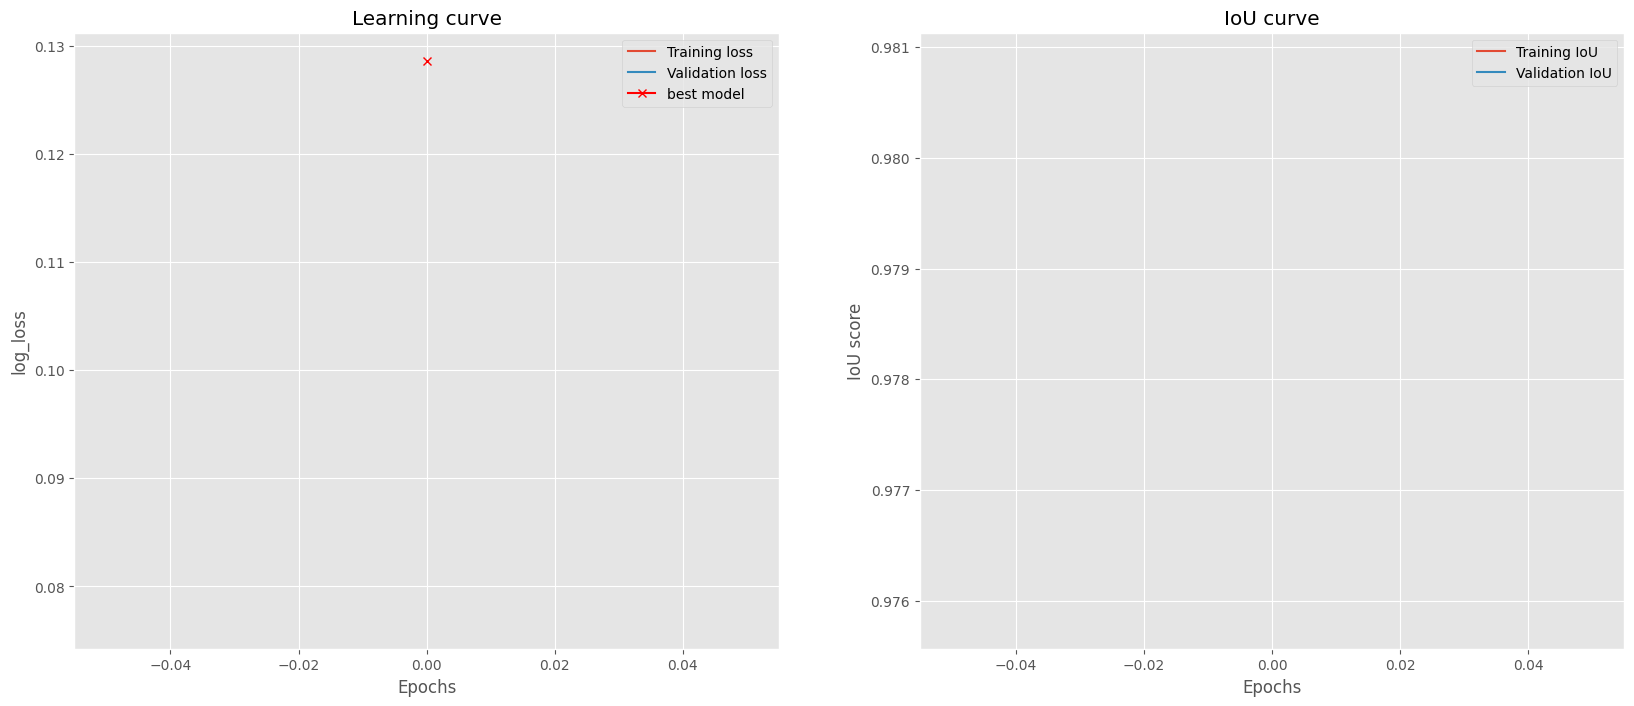

In [33]:
# Visualise the results of training
# Variables stored in results.history: val_loss, val_acc, val_IoU, loss, acc, IoU, lr
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(results.history["loss"], label="Training loss")
ax[0].plot(results.history["val_loss"], label="Validation loss")
ax[0].set_title('Learning curve')
ax[0].plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log_loss")
ax[0].legend();

ax[1].plot(results.history["val_IoU"], label="Training IoU")
ax[1].plot(results.history["IoU"], label="Validation IoU")
ax[1].set_title("IoU curve")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("IoU score")
ax[1].legend()

In [34]:
# # Evaluate on validation set (loss, acc, IoU)
model_apo.evaluate(X_valid, y_valid, verbose=2)

InvalidArgumentError:  Incompatible shapes: [32,256,256,1] vs. [32,256,256]
	 [[node dice_bce_score/add_3 (defined at C:\Users\Noah\AppData\Local\Temp\ipykernel_19248\165189558.py:100) ]] [Op:__inference_test_function_8141]

Errors may have originated from an input operation.
Input Source operations connected to node dice_bce_score/add_3:
 dice_bce_score/sub (defined at C:\Users\Noah\AppData\Local\Temp\ipykernel_19248\165189558.py:99)	
 dice_bce_score/logistic_loss (defined at C:\Users\Noah\AppData\Local\Temp\ipykernel_19248\165189558.py:97)

Function call stack:
test_function


In [ ]:
# Predict on training and validations sets
preds_train = model_apo.predict(X_train, verbose=1)
preds_val = model_apo.predict(X_valid, verbose=1)

# Threshold predictions (only keep predictions with a minimum level of confidence)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
results.history # Show the loss values (these are saved to a .csv file using 'CSVLogger' callback defined above)

In [ ]:
clear_session()

In [ ]:
model_apo = load_model("VGG16pre-Gastro-256.h5", custom_objects={'IoU': IoU})
model_apo.evaluate(X_valid, y_valid, verbose=2)